<a href="https://colab.research.google.com/github/gremlin97/EVA-8/blob/main/s9/s9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-lr-finder
!git clone https://github.com/gremlin97/EVA-Utils
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'EVA-Utils'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 105 (delta 58), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (105/105), 26.12 KiB | 8.71 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=20aaa3b2bd151c0f69ee86a9e9efc37264ad94e9b08fc9d466cd3bf17f71e935
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef6

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision.transforms.functional as TF

In [3]:
%cd EVA-Utils

/content/EVA-Utils


In [4]:
from main_gen import *
from utils import *

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Ultimus(nn.Module):
    def __init__(self):
        super(Ultimus, self).__init__()
        self.k = nn.Linear(48,8)
        self.q = nn.Linear(48,8)
        self.v = nn.Linear(48,8)
        self.out = nn.Linear(8,48)

    def forward(self, x):
        k = self.k(x) # Calculating k,q,v values from learnanble k,q,v learnable layers
        q = self.q(x)
        v = self.v(x)
        score = F.softmax(torch.matmul(q,k.T)/torch.sqrt(torch.tensor(k.shape[1])),dim=1) # score = softmax((k x q.Transpose)/root(k.shape))
        attention = torch.matmul(score,v) # Scaled dot-product attention (score x v)
        out = self.out(attention)
        return out

class Transformer(nn.Module):
  def __init__(self):
    super(Transformer,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)  # Set of three convolutions and gap to downscale image from 32x32x3 to 1x1x48
    self.conv2 = nn.Conv2d(16, 32, 3, 1, 1) # (in_c,out_c,kernel_size,stride,padding)
    self.conv3 = nn.Conv2d(32, 48, 3, 1, 1)
    self.gap = nn.AdaptiveAvgPool2d((1,1))
    self.ultimusBlock = Ultimus()
    self.cap = nn.Linear(48,10) # Final Prediction Layer
  
  def forward(self, x):
      x = self.conv3(F.relu(self.conv2(F.relu(self.conv1(x)))))
      x = self.gap(x)
      x = torch.flatten(x, 1)

      main = x
      # print(main.shape)
      residue = self.ultimusBlock(main) # Block 1
      # print(residue.shape)
      main = main + residue # Skip Connection input->2
      residue = self.ultimusBlock(main) # Block 2
      main = main + residue # Skip Connection 1->2
      residue = self.ultimusBlock(main) # Block 3
      main = main + residue # Skip Connection 2->3
      residue = self.ultimusBlock(main) #Block 4
      main = main + residue # Skip Connection 3->output

      # x = self.ultimusBlock(self.ultimusBlock(self.ultimusBlock(self.ultimusBlock(x))))
      main = self.cap(main)
      return main

In [10]:
ultimus = Transformer()
out = ultimus(torch.randn(2,3,32,32))
print(out)

tensor([[-0.7185, -0.9606, -0.9459,  0.2646, -0.0222, -0.5540, -0.1607, -0.5729,
         -0.0111,  0.8624],
        [-0.7186, -0.9616, -0.9462,  0.2640, -0.0229, -0.5562, -0.1619, -0.5745,
         -0.0112,  0.8634]], grad_fn=<AddmmBackward0>)


In [11]:
ultimus = ultimus.to(device)

In [12]:
from torchsummary import summary
summary(ultimus,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 32, 32, 32]           4,640
            Conv2d-3           [-1, 48, 32, 32]          13,872
 AdaptiveAvgPool2d-4             [-1, 48, 1, 1]               0
            Linear-5                    [-1, 8]             392
            Linear-6                    [-1, 8]             392
            Linear-7                    [-1, 8]             392
            Linear-8                   [-1, 48]             432
           Ultimus-9                   [-1, 48]               0
           Linear-10                    [-1, 8]             392
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                   [-1, 48]             432
          Ultimus-14                   

In [14]:
trainloader, testloader = init_dataloader(16)

In [15]:
optimizer, criterion = init_optim_any(ultimus, 0.001)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.74E-02


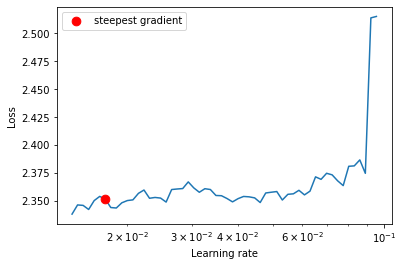

In [17]:
from torch_lr_finder import LRFinder
lr_finder = LRFinder(ultimus, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [18]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.01


In [19]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=100,
                                                three_phase=False, 
                                                final_div_factor=100,
                                                anneal_strategy='linear'
                                                ) 

In [21]:
loss_arr = train_gen(ultimus, 24, optimizer, trainloader, scheduler)

[1,  2000] loss: 1.890
Accuracy is: 31.2
LR is : [0.002875125008333889]
Epoch is: 0
[2,  2000] loss: 1.651
Accuracy is: 39.596
LR is : [0.004750250016667778]
Epoch is: 1
[3,  2000] loss: 1.534
Accuracy is: 44.552
LR is : [0.006625375025001668]
Epoch is: 2
[4,  2000] loss: 1.485
Accuracy is: 46.276
LR is : [0.008500500033335558]
Epoch is: 3
[5,  2000] loss: 1.450
Accuracy is: 47.712
LR is : [0.009895771]
Epoch is: 4
[6,  2000] loss: 1.417
Accuracy is: 43.414
LR is : [0.0093754585]
Epoch is: 5
[7,  2000] loss: 2.355
Accuracy is: 11.368
LR is : [0.008855146]
Epoch is: 6
[8,  2000] loss: 2.247
Accuracy is: 16.334
LR is : [0.0083348335]
Epoch is: 7
[9,  2000] loss: 2.034
Accuracy is: 24.206
LR is : [0.007814521]
Epoch is: 8
[10,  2000] loss: 1.908
Accuracy is: 28.388
LR is : [0.0072942085]
Epoch is: 9
[11,  2000] loss: 2.029
Accuracy is: 27.852
LR is : [0.006773896]
Epoch is: 10
[12,  2000] loss: 1.991
Accuracy is: 27.834
LR is : [0.0062535835]
Epoch is: 11
[13,  2000] loss: 2.620
Accuracy 

In [26]:
plot_arr, pre = test_gen(ultimus, testloader)

Accuracy of the model on the 10000 test images: 41 %


In [28]:
Train_Logs=([
    '''
      [1,  2000] loss: 1.890
      Accuracy is: 31.2
      LR is : [0.002875125008333889]
      Epoch is: 0
      [2,  2000] loss: 1.651
      Accuracy is: 39.596
      LR is : [0.004750250016667778]
      Epoch is: 1
      [3,  2000] loss: 1.534
      Accuracy is: 44.552
      LR is : [0.006625375025001668]
      Epoch is: 2
      [4,  2000] loss: 1.485
      Accuracy is: 46.276
      LR is : [0.008500500033335558]
      Epoch is: 3
      [5,  2000] loss: 1.450
      Accuracy is: 47.712
      LR is : [0.009895771]
      Epoch is: 4
      [6,  2000] loss: 1.417
      Accuracy is: 43.414
      LR is : [0.0093754585]
      Epoch is: 5
      [7,  2000] loss: 2.355
      Accuracy is: 11.368
      LR is : [0.008855146]
      Epoch is: 6
      [8,  2000] loss: 2.247
      Accuracy is: 16.334
      LR is : [0.0083348335]
      Epoch is: 7
      [9,  2000] loss: 2.034
      Accuracy is: 24.206
      LR is : [0.007814521]
      Epoch is: 8
      [10,  2000] loss: 1.908
      Accuracy is: 28.388
      LR is : [0.0072942085]
      Epoch is: 9
      [11,  2000] loss: 2.029
      Accuracy is: 27.852
      LR is : [0.006773896]
      Epoch is: 10
      [12,  2000] loss: 1.991
      Accuracy is: 27.834
      LR is : [0.0062535835]
      Epoch is: 11
      [13,  2000] loss: 2.620
      Accuracy is: 23.024
      LR is : [0.005733271]
      Epoch is: 12
      [14,  2000] loss: 2.439
      Accuracy is: 20.378
      LR is : [0.0052129585]
      Epoch is: 13
      [15,  2000] loss: 2.007
      Accuracy is: 27.008
      LR is : [0.004692646]
      Epoch is: 14
      [16,  2000] loss: 2.094
      Accuracy is: 26.106
      LR is : [0.004172333499999999]
      Epoch is: 15
      [17,  2000] loss: 2.133
      Accuracy is: 27.968
      LR is : [0.003652021]
      Epoch is: 16
      [18,  2000] loss: 1.899
      Accuracy is: 31.358
      LR is : [0.0031317085]
      Epoch is: 17
      [19,  2000] loss: 3.167
      Accuracy is: 25.052
      LR is : [0.0026113959999999993]
      Epoch is: 18
      [20,  2000] loss: 2.364
      Accuracy is: 26.042
      LR is : [0.0020910835000000003]
      Epoch is: 19
      [21,  2000] loss: 1.943
      Accuracy is: 28.592
      LR is : [0.0015707710000000003]
      Epoch is: 20
      [22,  2000] loss: 1.848
      Accuracy is: 33.438
      LR is : [0.0010504584999999986]
      Epoch is: 21
      [23,  2000] loss: 1.741
      Accuracy is: 37.39
      LR is : [0.0005301460000000004]
      Epoch is: 22
      [24,  2000] loss: 1.683
      Accuracy is: 39.042
      LR is : [9.83349999999876e-06]
      Epoch is: 23
      Finished Training

      Accuracy of the model on the 10000 test images: 41 %
    '''
])